In [39]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stockenv import StockTradingEnv
from optionsenv import OptionTradingEnv
from coveredcallenv import CoveredCallTradingEnv
from actor_critic_model import ActorCritic
import seaborn as sns
import pandas as pd


ENV_TO_USE = CoveredCallTradingEnv


def random_policy(state, action_dim=2):
    """Simple random policy that outputs random actions"""
    action_type = action_type = np.random.randint(0, 5)  # 0: buy, 1: sell, 2: hold
    action_amount = np.random.random()  # Random amount between 0 and 1
    return np.array([action_type, action_amount])

def evaluate_policy(env, policy, num_episodes=5):
    """Evaluate a policy for multiple episodes"""
    episode_returns = []
    
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        portfolio_values = [info['portfolio_value']]
        
        while not done:
            if isinstance(policy, PPO):
                action, _ = policy.predict(state, deterministic=True)
            elif isinstance(policy, ActorCritic):
                action = policy.get_action(state, deterministic=True)
            else:  # Random policy
                action = policy(state)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            portfolio_values.append(info['portfolio_value'])
            state = next_state
        
        # Calculate returns as percentage change from initial value
        returns = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
        episode_returns.append(returns)
    
    return np.mean(episode_returns), np.std(episode_returns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
train_env_params = {
        'initial_cash': 10000.0,
        'initial_stock_price': 100,
        'mu': -0.01,
        'sigma': 0.3,
        'risk_free_rate': 0.01,
        'max_steps': 60,  
        'history_length': 30
    }

test_env_params = {
    'initial_cash': 10000.0,
    'initial_stock_price': 100,
    'mu': -0.01,
    'sigma': 0.3,
    'risk_free_rate': 0.01,
    'max_steps': 60,  # One trading year
    'history_length': 30
}

In [ ]:
steps = 2000
env = ENV_TO_USE(**train_env_params)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Initialize policies
ppo = PPO("MlpPolicy", env, seed=10)
for iteration in range(500):
    print(iteration)
    # Train policies
    print("Training PPO...")
    ppo.learn(total_timesteps=1000)


    # Evaluate policies
    policies = {
        'PPO': ppo,
    }


    test_env = ENV_TO_USE(**test_env_params)
    obs = test_env.reset()
    obs=obs[0]
    for i in range(60):
        action, _state = ppo.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)
        print(f"Action: {action} obs: {obs} reward: {reward}")
        if terminated or truncated:
            break
        test_env.render()
        

    plt.figure(figsize=(16, 8), dpi=150) 
    env_states = test_env.render()
    env_states = pd.DataFrame(env_states)

    env_states['portfolio_values_returns'] = env_states['portfolio_values']-env_states['portfolio_values'].iloc[0]
    env_states['stock_prices_returns'] = env_states['stock_prices']-env_states['stock_prices'].iloc[0]
    env_states['portfolio_values_returns'] = env_states['portfolio_values_returns'].fillna(0)
    env_states['stock_prices_returns'] = env_states['stock_prices_returns'].fillna(0)
    env_states['stock_prices_returns'] = env_states['stock_prices_returns']/env_states['stock_prices'].iloc[0]
    env_states['portfolio_values_returns'] = env_states['portfolio_values_returns']/env_states['portfolio_values'].iloc[0]

    # using plot method to plot open prices. 
    # in plot method we set the label and color of the curve. 
    env_states['stock_prices_returns'].plot(label='stock_price', color='orange') 
    env_states['portfolio_values_returns'].plot(label='portfolio_value', color='blue') 

    # adding title to the plot 
    plt.title('Stock Price and Portfolio Value') 

    # adding Label to the x-axis 
    plt.xlabel('Time') 

    # adding legend to the curve 
    plt.legend() 
    plt.savefig(f'portfolio_value_over_{iteration}.png')
    plt.close()




In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define market conditions (name, mu, sigma)
market_conditions = [
    # ("steady-volatile", 0.001, 0.05),
    ("growing-volatile", 0.1, 0.05),
    ("growing-stable", 0.1, 0.005),
    ("downward-volatile", -0.1, 0.05),
    ("downward-stable", -0.1, 0.005)
]

risk_free_rate = 0.01

# Folder for saving plots
output_folder = "graphs"
os.makedirs(output_folder, exist_ok=True)

# Loop over each market condition
for condition_name, mu_value, sigma_value in market_conditions:
    print(f"Running market condition: {condition_name} (mu={mu_value}, sigma={sigma_value})")
    
    # Update environment parameters (assumes train_env_params and test_env_params are defined)
    current_train_env_params = train_env_params.copy()
    current_test_env_params = test_env_params.copy()
    current_train_env_params.update({'mu': mu_value, 'sigma': sigma_value, 'risk_free_rate': risk_free_rate})
    current_test_env_params.update({'mu': mu_value, 'sigma': sigma_value, 'risk_free_rate': risk_free_rate})
    
    # Initialize training environment and PPO policy
    env = ENV_TO_USE(**current_train_env_params)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    ppo = PPO("MlpPolicy", env, seed=10)
    
    # Training and evaluation loop
    for epoch in range(300):
        print(f"Market: {condition_name} | Epoch: {epoch}")
        
        # Train PPO
        print("Training PPO...")
        ppo.learn(total_timesteps=1000)

        if epoch % 5==0:
            # Evaluate the current policy on the test environment
            test_env = ENV_TO_USE(**current_test_env_params)
            obs = test_env.reset()
            # Adjust if your environment reset returns a tuple
            if isinstance(obs, (list, tuple)):
                obs = obs[0]
            
            for i in range(60):
                action, _state = ppo.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = test_env.step(action)
                print(f"Action: {action} | obs: {obs} | reward: {reward}")
                if terminated or truncated:
                    break
                test_env.render()
        
            # Create a plot of performance
            plt.figure(figsize=(16, 8), dpi=150)
            # Here we assume test_env.render() returns a dict-like object to be converted to DataFrame
            env_states = test_env.render()
            env_states = pd.DataFrame(env_states)
        
            # Compute returns (difference from initial value)
            env_states['portfolio_values_returns'] = env_states['portfolio_values'] - env_states['portfolio_values'].iloc[0]
            env_states['stock_prices_returns'] = env_states['stock_prices'] - env_states['stock_prices'].iloc[0]
            env_states['portfolio_values_returns'] = env_states['portfolio_values_returns'].fillna(0)
            env_states['stock_prices_returns'] = env_states['stock_prices_returns'].fillna(0)
            env_states['portfolio_values_returns'] = env_states['portfolio_values_returns'] / env_states['portfolio_values'].iloc[0]
            env_states['stock_prices_returns'] = env_states['stock_prices_returns'] / env_states['stock_prices'].iloc[0]
        
            # Plot both series
            env_states['stock_prices_returns'].plot(label='stock_price', color='orange')
            env_states['portfolio_values_returns'].plot(label='portfolio_value', color='blue')
        
            plt.title(f'Stock Price and Portfolio Value - Epoch {epoch}, mu={mu_value}, sigma={sigma_value}')
            plt.xlabel('Time')
            plt.legend()
        
            # Save plot in the designated folder
            condition_folder = os.path.join(output_folder, condition_name)
            os.makedirs(condition_folder, exist_ok=True)
            filename = f"epoch_{epoch}_mu_{mu_value}_sigma_{sigma_value}.png"
            filepath = os.path.join(condition_folder, filename)
            plt.savefig(filepath)
            plt.close()


Running market condition: steady-volatile (mu=0.001, sigma=0.05)
Market: steady-volatile | Epoch: 0
Training PPO...


/home/maharshi_patel/.airconda-environments/rltrader/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Action: [0.         0.08499949] | obs: [ 1.0209692e+00  1.0273330e+00  1.0315571e+00  1.0315471e+00
  1.0337523e+00  1.0319990e+00  1.0310758e+00  1.0300777e+00
  1.0264512e+00  1.0236034e+00  1.0260530e+00  1.0267268e+00
  1.0272825e+00  1.0231857e+00  1.0197161e+00  1.0167754e+00
  1.0089860e+00  1.0060650e+00  1.0100205e+00  1.0093012e+00
  1.0074563e+00  1.0085357e+00  1.0052520e+00  1.0061760e+00
  1.0037889e+00  9.9979371e-01  9.9759406e-01  9.9501890e-01
  9.9308538e-01  9.9941957e-01  9.2113322e-01  7.8912571e-02
  0.0000000e+00  1.0000458e+00  7.8912571e-02  0.0000000e+00
  6.2332004e-03  4.1116653e-03 -9.7212796e-06  2.1378826e-03
 -1.6960724e-03 -8.9463848e-04 -9.6799491e-04 -3.5205970e-03
 -2.7744265e-03  2.3930469e-03  6.5681001e-04  5.4116087e-04
 -3.9879624e-03 -3.3910091e-03 -2.8839086e-03 -7.6608034e-03
 -2.8950053e-03  3.9316076e-03 -7.1206101e-04 -1.8279684e-03
  1.0714880e-03 -3.2559999e-03  9.1922790e-04 -2.3724523e-03
 -3.9801397e-03 -2.2000957e-03 -2.5813361e-03 

KeyboardInterrupt: 

[]

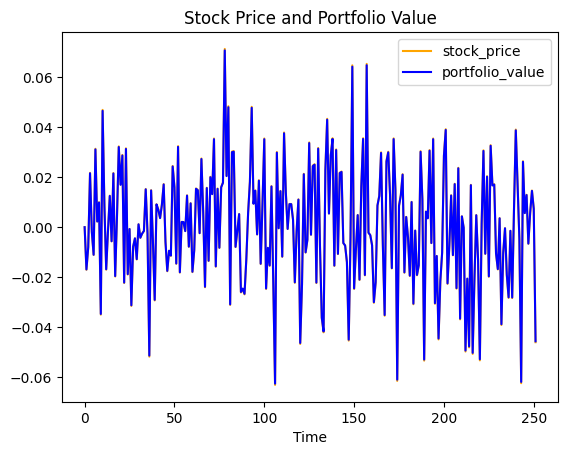

In [42]:
# using plot method to plot open prices. 
# in plot method we set the label and color of the curve. 
env_states['stock_prices_returns'].plot(label='stock_price', color='orange') 
env_states['portfolio_values_returns'].plot(label='portfolio_value', color='blue') 

# adding title to the plot 
plt.title('Stock Price and Portfolio Value') 

# adding Label to the x-axis 
plt.xlabel('Time') 

# adding legend to the curve 
plt.legend() 
plt.plot()

In [30]:
env = CoveredCallTradingEnv()
obs, info = env.reset()
done = False
while not done:
    if env.current_step == 0:
        action = [0, 1.0]  # Buy stock with all cash
    elif env.current_step % 30 == 0 and env.portfolio.current_holdings["STOCK"] > 0:
        action = [3, 1.0]  # Sell covered call
    else:
        action = [2, 0.0]  # Hold
    obs, reward, done, _, info = env.step(action)
    env.render()


===== Step 1 | Date: 2025-03-29 =====
Stock Price: $102.28
Cash: $16.36
Stock Value: $10023.75
Stock Quantity: 98
Options Value: $0.00
Total Portfolio Value: $10040.11
Return since start: 0.40%

===== Step 2 | Date: 2025-03-30 =====
Stock Price: $103.74
Cash: $16.36
Stock Value: $10166.38
Stock Quantity: 98
Options Value: $0.00
Total Portfolio Value: $10182.75
Return since start: 1.83%

===== Step 3 | Date: 2025-03-31 =====
Stock Price: $105.91
Cash: $16.36
Stock Value: $10378.83
Stock Quantity: 98
Options Value: $0.00
Total Portfolio Value: $10395.19
Return since start: 3.95%

===== Step 4 | Date: 2025-04-01 =====
Stock Price: $105.85
Cash: $16.36
Stock Value: $10373.64
Stock Quantity: 98
Options Value: $0.00
Total Portfolio Value: $10390.01
Return since start: 3.90%

===== Step 5 | Date: 2025-04-02 =====
Stock Price: $106.10
Cash: $16.36
Stock Value: $10397.73
Stock Quantity: 98
Options Value: $0.00
Total Portfolio Value: $10414.10
Return since start: 4.14%

===== Step 6 | Date: 202

In [ ]:
# steady-volative, growing-volatile, growing-stable, downward-volative, downward-stable
# risk-free rate = 0.01
mu = [0.001, 0.1, 0.1, -0.1, -0.1]
sigma = [0.05, 0.05, 0.005, 0.05, 0.005]

#stocks
#options (covered calls)

# actor crtic, ppo, random